# Content-based recommender using Deep Structured Semantic Model

An example of how to build a Deep Structured Semantic Model (DSSM) for incorporating complex content-based features into a recommender system.  See [Learning Deep Structured Semantic Models for Web Search using Clickthrough Data](https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/).  This example does not attempt to provide a datasource or train a model, but merely show how to structure a complex DSSM network.

In [1]:
import warnings

import mxnet as mx
from mxnet import gluon, nd, autograd, sym
import numpy as np
import symbol_alexnet as alexnet
from sklearn.random_projection import johnson_lindenstrauss_min_dim


In [100]:
# Define some constants
max_user = int(1e5)
title_vocab_size = int(3e4)
query_vocab_size = int(3e4)
num_samples = int(1e4)
hidden_units = 128
epsilon_proj = 0.25

ctx = mx.gpu() if len(mx.test_utils.list_gpus()) > 0 else mx.cpu()

## Bag of words random projection

A previous version of this example contained a bag of word random projection example, it is kept here for reference but not used in the next example.
Random Projection is a dimension reduction technique that guarantees the disruption of the pair-wise distance between your original data point within a certain bound.
What is even more interesting is that the dimension to project onto to guarantee that bound does not depend on the original number of dimension but solely on the total number of datapoints.
You can see more explanation [in this blog post](http://jasonpunyon.com/blog/2017/12/02/fun-with-random-numbers-random-projection/)

In [101]:
proj_dim = johnson_lindenstrauss_min_dim(num_samples, epsilon_proj)
print("To keep a distance disruption ~< {}% of our {} samples we need to randomly project to at least {} dimensions".format(epsilon_proj*100, num_samples, proj_dim))

To keep a distance disruption ~< 25.0% of our 10000 samples we need to randomly project to at least 1414 dimensions


In [102]:
class BagOfWordsRandomProjection(gluon.HybridBlock):
    def __init__(self, vocab_size, output_dim, random_seed=54321, pad_index=0):
        """
        :param int vocab_size: number of element in the vocabulary
        :param int output_dim: projection dimension
        :param int ramdon_seed: seed to use to guarantee same projection
        :param int pad_index: index of the vocabulary used for padding sentences
        """
        super(BagOfWordsRandomProjection, self).__init__()
        self._vocab_size = vocab_size
        self._output_dim = output_dim
        proj = self._random_unit_vecs(vocab_size=vocab_size, output_dim=output_dim, random_seed=random_seed)
        # we set the projection of the padding word to 0
        proj[pad_index, :] = 0
        self.proj = self.params.get_constant('proj', value=proj)

    def _random_unit_vecs(self, vocab_size, output_dim, random_seed):
        rs = np.random.RandomState(seed=random_seed)
        W = rs.normal(size=(vocab_size, output_dim))
        Wlen = np.linalg.norm(W, axis=1)
        W_unit = W / Wlen[:,None]
        return W_unit

    def hybrid_forward(self, F, x, proj):
        """
        :param nd or sym F:
        :param nd.NDArray x: index of tokens
        returns the sum of the projected embeddings of each token
        """
        embedded = F.Embedding(x, proj, input_dim=self._vocab_size, output_dim=self._output_dim)
        return embedded.sum(axis=1)

In [103]:
bowrp = BagOfWordsRandomProjection(1000, 20)
bowrp.initialize()

In [104]:
bowrp(mx.nd.array([[10, 50, 100], [5, 10, 0]]))


[[ 0.35554492  0.0736109  -0.1220893   0.11155054 -0.20963743  0.21141198
   0.12296599  0.12428369 -0.10999548 -0.16867855 -0.09068598  0.14154953
  -0.24029303  0.11956739  0.02830955 -0.14226514 -0.45963028 -0.5456747
  -0.5663947  -0.10585886]
 [-0.31655627 -0.13582113 -0.13815539  0.42596683  0.25674546  0.5024462
  -0.3122709   0.01826438 -0.0277671  -0.14526835  0.44378105  0.09626544
   0.24572927  0.36588538  0.17922089 -0.21583243 -0.30497772  0.19484927
  -0.20705326 -0.13759173]]
<NDArray 2x20 @cpu(0)>

With padding:

In [105]:
bowrp(mx.nd.array([[10, 50, 100, 0], [5, 10, 0, 0]]))


[[ 0.35554492  0.0736109  -0.1220893   0.11155054 -0.20963743  0.21141198
   0.12296599  0.12428369 -0.10999548 -0.16867855 -0.09068598  0.14154953
  -0.24029303  0.11956739  0.02830955 -0.14226514 -0.45963028 -0.5456747
  -0.5663947  -0.10585886]
 [-0.31655627 -0.13582113 -0.13815539  0.42596683  0.25674546  0.5024462
  -0.3122709   0.01826438 -0.0277671  -0.14526835  0.44378105  0.09626544
   0.24572927  0.36588538  0.17922089 -0.21583243 -0.30497772  0.19484927
  -0.20705326 -0.13759173]]
<NDArray 2x20 @cpu(0)>

# Content-based recommender / ranking system using DSSM

For example in the search result ranking problem:
You have users, that have performed text-based searches. They were presented with results, and selected one of them.
Results are composed of a title and an image.

Your positive examples will be the clicked items in the search results, and the negative examples are sampled from the non-clicked examples.

The network will jointly learn embeddings for users and query text making up the "Query", title and image making the "Item" and learn how similar they are.

After training, you can index the embeddings for your items and do a knn search with your query embeddings using the cosine similarity to return ranked items

In [111]:
proj_dim = 128

In [126]:
class DSSMRecommenderNetwork(gluon.HybridBlock):
    def __init__(self, query_vocab_size, proj_dim, max_user, title_vocab_size, hidden_units, random_seed=54321, p=0.5):
        super(DSSMRecommenderNetwork, self).__init__()
        with self.name_scope():
            
            # User/Query pipeline
            self.user_embedding = gluon.nn.Embedding(max_user, proj_dim)
            self.user_mlp = gluon.nn.Dense(hidden_units, activation="relu")
            
            # Instead of bag of words, we use learned embeddings + stacked biLSTM average
            self.query_text_embedding = gluon.nn.Embedding(query_vocab_size, proj_dim)
            self.query_lstm = gluon.rnn.LSTM(hidden_units, 2, bidirectional=True)
            self.query_text_mlp = gluon.nn.Dense(hidden_units, activation="relu")            
            
            self.query_dropout = gluon.nn.Dropout(p)
            self.query_mlp = gluon.nn.Dense(hidden_units, activation="relu")

            # Item pipeline
            # Instead of bag of words, we use learned embeddings + stacked biLSTM average
            self.title_embedding = gluon.nn.Embedding(title_vocab_size, proj_dim)
            self.title_lstm = gluon.rnn.LSTM(hidden_units, 2, bidirectional=True)
            self.title_mlp = gluon.nn.Dense(hidden_units, activation="relu")
            
            # You could use vgg here for example
            self.image_embedding = gluon.model_zoo.vision.resnet18_v2(pretrained=False).features 
            self.image_mlp = gluon.nn.Dense(hidden_units, activation="relu")
            
            self.item_dropout = gluon.nn.Dropout(p)
            self.item_mlp = gluon.nn.Dense(hidden_units, activation="relu")
    
    def hybrid_forward(self, F, user, query_text, title, image):
        # Query
        user = self.user_embedding(user)
        user = self.user_mlp(user)

        query_text = self.query_text_embedding(query_text)
        query_text = self.query_lstm(query_text.transpose((1,0,2)))
        # average the states
        query_text = query_text.mean(axis=0)
        query_text = self.query_text_mlp(query_text)
        
        query = F.concat(user, query_text)
        query = self.query_dropout(query)
        query = self.query_mlp(query)
        
        # Item
        title_text = self.title_embedding(title)
        title_text = self.title_lstm(title_text.transpose((1,0,2)))
        # average the states
        title_text = title_text.mean(axis=0)
        title_text = self.title_mlp(title_text)
        
        image = self.image_embedding(image)
        image = self.image_mlp(image)
        
        item = F.concat(title_text, image)
        item = self.item_dropout(item)
        item = self.item_mlp(item)
        
        # Cosine Similarity
        query = query.expand_dims(axis=2)
        item = item.expand_dims(axis=2)
        sim = F.batch_dot(query, item, transpose_a=True) / (query.norm(axis=1) * item.norm(axis=1) + 1e-9).expand_dims(axis=2)
        
        return sim.squeeze(axis=2)

In [127]:
network = DSSMRecommenderNetwork(
    query_vocab_size,
    proj_dim,
    max_user,
    title_vocab_size,
    hidden_units
)


network.initialize(mx.init.Xavier(), ctx)

# Load pre-trained vgg16 weights
with network.name_scope():
    network.image_embedding = gluon.model_zoo.vision.resnet18_v2(pretrained=True, ctx=ctx).features

It is quite hard to visualize the network since it is relatively complex but you can see the two-pronged structure, and the resnet18 branch

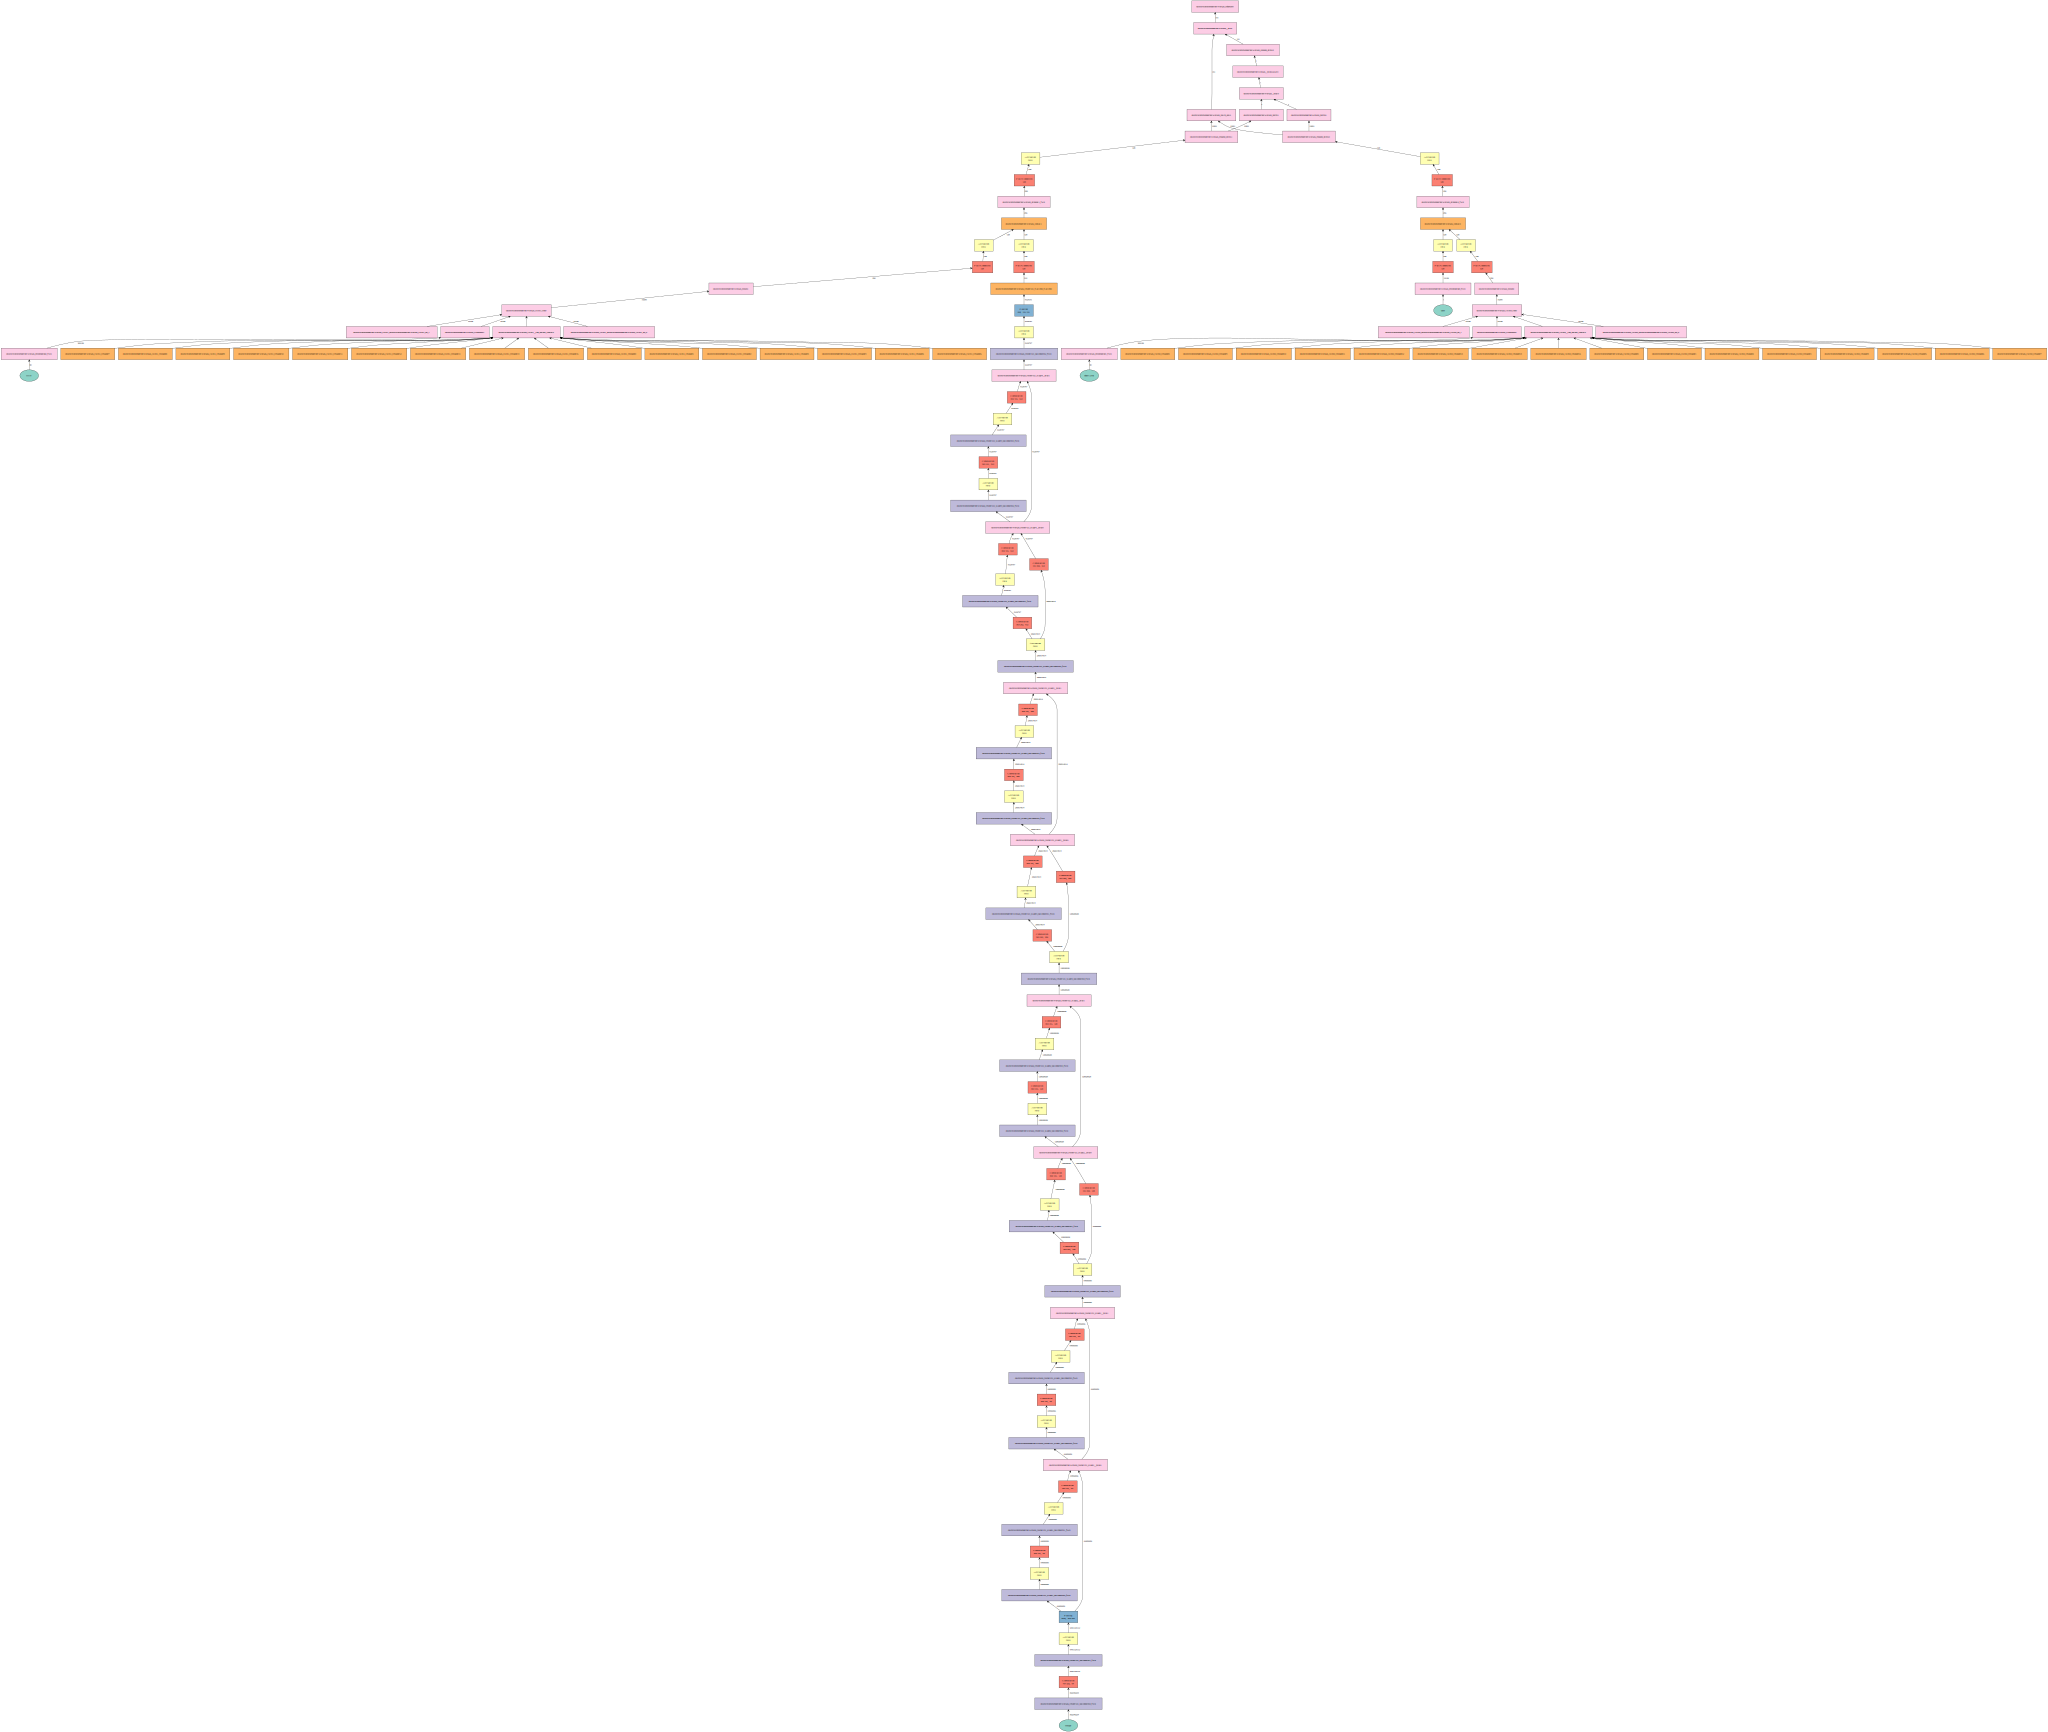

In [128]:
mx.viz.plot_network(network(
                        mx.sym.var('user'), mx.sym.var('query_text'), mx.sym.var('title'), mx.sym.var('image')),
                    shape={'user': (1,1), 'query_text': (1,30), 'title': (1,30), 'image': (1,3,224,224)},
                    node_attrs={"fixedsize":"False"})

We can print the summary of the network using dummy data. We can see it is already training on 32M parameters!

In [129]:
user  = mx.nd.array([[200], [100]], ctx)
query = mx.nd.array([[10, 20, 0, 0, 0], [40, 50, 0, 0, 0]], ctx) # Example of an encoded text
title = mx.nd.array([[10, 20, 0, 0, 0], [40, 50, 0, 0, 0]], ctx) # Example of an encoded text
image = mx.nd.random.uniform(shape=(2,3, 224,224), ctx=ctx) # Example of an encoded image


network.summary(user, query, title, image)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input    (2, 1), (2, 5), (2, 5), (2, 3, 224, 224)               0
         Embedding-1                                 (2, 1, 128)        12800000
        Activation-2  <Symbol dssmrecommendernetwork26_dense0_relu_fwd>               0
        Activation-3                                    (2, 128)               0
             Dense-4                                    (2, 128)           16512
         Embedding-5                                 (2, 5, 128)         3840000
              LSTM-6                                 (5, 2, 256)          659456
        Activation-7  <Symbol dssmrecommendernetwork26_dense1_relu_fwd>               0
        Activation-8                                    (2, 128)               0
             Dense-9                                    (2, 128)           32896
          Drop

In [130]:
network(user, query, title, image)


[[0.36884642]
 [0.30626413]]
<NDArray 2x1 @gpu(0)>

The output is the similarity, if we wanted to train it on real data, we would need to minimize the Cosine loss, 1 - cosine_similarity.